In [652]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn
from sklearn.datasets import make_moons

In [653]:
X, y = make_moons(2500,shuffle=True, noise=0.05, random_state=225)

In [654]:
def visualise_boundary(model):
    """
    Prints plot with model's decision boundary included.
    """
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]

    probs = model.predict(grid).reshape(xx.shape)

    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                        vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.show()

In [655]:
class LogisticRegression():
    """
    Linear model for binary classification.
    """
    def __init__(self, solver='sag', 
                       learning_rate=0.1,
                       penalty='l2', 
                       C=1.0,
                       max_iter=100,
                       tol=1e-6,
                       iters_to_stop=5):
        """
        Initializes new LogisticRegression model instance.
        ---------------
        Parameters:
        ---------------
            solver = {'liblinear', 'sag', 'saga', 'newton-cg', 'lbfgs'}, default='sag'
                Defines method to solve logloss gradient descent problem embedded.
            learning_rate: float, default=0.1
                Defines step proportion for gradient descent.
            penalty = {'none', 'l1', 'l2'}, default='l2'
                Type of regularization used for solving.
            C: float, default=1.0
                Regularization constant.
            max_iter: int, default=100
                Upper boundary for number of iterations.
            tol:float, default=1e-6
                Early stopping tolerance.
            iters_to_stop: int, default=5
                Idle iterations quantity needed to stop descending.
        """
        self.solver = solver
        self.learning_rate = learning_rate
        self.penalty = penalty
        self.max_iter = max_iter
        self.tol = tol
        self.iters_to_stop = iters_to_stop
        self.c = C
        self.idle_iters = 0      
        pass

    def early_stop_check(self):
        """
        Inner method called while fit() is performing to check if
        model has converged to it's minima.
        Returns True or False respectively.
        """
        if (self.a_grad - self.prev_grad).mean() <= self.tol:
            self.idle_iters += 1
            if self.idle_iters >= self.iters_to_stop:
                return True
        else:
            self.idle_iters = 0
        return False

    def logloss(self, y_true, y_pred):
        """
        Calculates logloss using formula:
            logloss(y_true, y_pred) = -1/n * sum(y_true*ln(y_pred) + (1 - y_true)*ln(1 - y_pred))
        """
        return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def fit(self, X, y):
        """
        Fits logistic regression coefficients to X and y.
        Returns self.
        """
        self.coef_ = np.zeros(X.shape[1])
        self.bias = 0
        self.a_grad = np.zeros(X.shape[1])
        self.b_grad = 0

        self.prev_error = 0
        self.useless_iterations = 0
        
        if self.solver == 'sag':
            for ep in range(self.max_iter):          
                y_pred = 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
                error = y_pred.ravel() - y

                rand_i = np.random.randint(0, X.shape[1])
                if self.penalty == 'none':
                    self.a_grad[rand_i] = (X[:,rand_i]*error).mean()
                if self.penalty == 'l1':
                    raise ValueError('Can\'t solve with \'penalty\'=%s with \'%s\' solver' % (self.penalty,
                                                                                              self.solver))
                if self.penalty == 'l2':
                    self.a_grad[rand_i] = (X[:,rand_i]*error).mean() + 2*self.c*self.coef_[rand_i]/len(X[:,rand_i])
                
                self.b_grad = error.mean()
                
                self.coef_ -= self.learning_rate * self.a_grad# / self.a_grad.shape[0]
                self.bias -= self.learning_rate * self.b_grad
        if self.solver == 'saga':
            for ep in range(self.max_iter):         
                y_pred = 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
                error = y_pred.ravel() - y

                rand_i = np.random.randint(0, X.shape[1])
                prev_a_grad_i = self.a_grad[rand_i]
                self.a_grad[rand_i] = (X[:,rand_i]*error).mean()
                curr_a_grad_i = self.a_grad[rand_i]
                saga_step = self.a_grad.copy() #/ self.a_grad.shape[0]
                
                saga_step[rand_i] += curr_a_grad_i - prev_a_grad_i
                self.b_grad = error.mean()
                
                self.coef_ -= self.learning_rate * saga_step
                self.bias -= self.learning_rate * self.b_grad
            pass
        if self.solver == 'liblinear':   
            self.a_grad.fill(1e100)
            prev_grad = np.zeros(X.shape[1])
            while self.a_grad.mean() - prev_grad.mean() > self.tol:
                for i in range(X.shape[1]):
                    for ep in range(self.max_iter):
                        y_pred = 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
                        error = y_pred.ravel() - y
                        if self.penalty == 'none':
                            raise ValueError('Can\'t solve with \'penalty\'=%s with \'%s\' solver' % (self.penalty,
                                                                                                      self.solver))       
                        if self.penalty == 'l1':
                            self.a_grad[i] = (X[:,i]*error).mean() + np.sign(self.coef_[i])*self.c/len(X[:,i])
                        if self.penalty == 'l2':
                            self.a_grad[i] = (X[:,i]*error).mean() + 2*self.c*self.coef_[i]/len(X[:,i])
                        self.coef_[i] -= self.learning_rate*self.a_grad[i]
                        prev_grad = self.a_grad
                    self.b_grad = error.mean()
                    self.bias -= self.learning_rate*self.b_grad
            pass
        if self.solver == 'newton-cg':
            # made for the sake of lerning rate unification
            # otherwise it converges too slow
            fake_constant = 5
            for ep in range(self.max_iter):
                y_pred = 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
                error = y_pred.ravel() - y

                for i in range(X.shape[1]):
                    self.a_grad[i] = (X[:,i]*error).mean()
                self.b_grad = error.mean()

                if self.penalty == 'none':                               
                    hessian_inv = np.linalg.inv(X.T @ np.diag(y_pred * (1 - y_pred)) @ X)
                if self.penalty == 'l1':
                    raise ValueError('Can\'t solve with \'penalty\'=%s with \'%s\' solver' % (self.penalty,
                                                                                                self.solver))
                if self.penalty == 'l2':
                    hessian_inv = np.linalg.inv(X.T @ 
                                                np.diag(y_pred * (1 - y_pred)) @ 
                                                X 
                                                + self.c*np.mean(np.sqrt(self.a_grad ** 2)))

                step = hessian_inv @ self.a_grad
                self.coef_ -= fake_constant*self.learning_rate*step
                self.bias -= fake_constant*self.learning_rate*self.b_grad
            pass
        if self.solver == 'lbfgs':
            m = 25
            delta_omega_prev = np.random.standard_normal((m+1, X.shape[1]))
            delta_grad_prev = np.random.standard_normal((m+1, X.shape[1]))
            prev_grad = np.random.standard_normal(X.shape[1])
            prev_omega = np.random.standard_normal(X.shape[1])
            for ep in range(self.max_iter):
                y_pred = 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
                error = y_pred.ravel() - y   
                self.b_grad = error.mean()  
                if self.penalty == 'none':
                    for i in range(X.shape[1]):
                        self.a_grad[i] = (X[:,i]*error).mean()  
                    q = self.a_grad.copy()
                    alpha = np.zeros(min(m, ep))
                    for i in range(min(m-1, ep-1), 0, -1):
                        rho_i = 1 / ((delta_grad_prev[i]) @ delta_omega_prev[i])
                        alpha[i] = rho_i * delta_omega_prev[i] @ q
                        q -= alpha[i]*(delta_grad_prev[i])

                    fill_ind = min(ep, m)
                    gamma = delta_omega_prev[fill_ind-1] @ delta_grad_prev[fill_ind-1] /  \
                            delta_grad_prev[fill_ind-1] @ delta_grad_prev[fill_ind-1] if ep > 0 else \
                            1

                    z = gamma * q

                    for i in range(0, min(m,ep)):   
                        rho_i = 1 / ((delta_grad_prev[i]) @ delta_omega_prev[i])
                        beta_i = rho_i * delta_grad_prev[i] @ z
                        z += delta_omega_prev[i]*(alpha[i] - beta_i)
                        
                    if ep <= m:
                        delta_grad_prev[ep] = self.a_grad - prev_grad
                        delta_omega_prev[ep] = self.coef_ - prev_omega
                    else:
                        delta_grad_prev = np.roll(delta_grad_prev, X.shape[1])
                        delta_grad_prev[m-1] = self.a_grad - prev_grad
                        delta_omega_prev = np.roll(delta_omega_prev, X.shape[1])
                        delta_omega_prev[m-1] = self.coef_ - prev_omega
                    prev_grad = self.a_grad.copy()
                    prev_omega = self.coef_.copy()
                    
                    self.coef_ -= self.learning_rate*z                
                    self.bias -= self.learning_rate*self.b_grad
                if self.penalty == 'l1':
                    raise ValueError('Can\'t solve with \'penalty\'=%s with \'%s\' solver' % (self.penalty,
                                                                                              self.solver))       
                if self.penalty == 'l2':
                    mu_k = self.c
                    mu_min = min(1e-3, mu_k)

                    gamma_1 = 0.75
                    eta_2 = 0.9
                    
                    for i in range(X.shape[1]):
                        self.a_grad[i] = (X[:,i]*error).mean()  
                    q = self.a_grad.copy()
                    alpha = np.zeros(min(m, ep))
                    for i in range(min(m-1, ep-1), 0, -1):
                        rho_i = 1 / ((delta_grad_prev[i] + mu_k*delta_omega_prev[i]) @ delta_omega_prev[i])
                        alpha[i] = rho_i * delta_omega_prev[i] @ q
                        q -= alpha[i]*(delta_grad_prev[i] + mu_k*delta_omega_prev[i])
                
                    fill_ind = min(ep, m)
                    gamma = delta_omega_prev[fill_ind-1] @ delta_grad_prev[fill_ind-1] /  \
                            delta_grad_prev[fill_ind-1] @ delta_grad_prev[fill_ind-1] if ep > 0 else \
                            1
                
                    z = gamma * q

                    for i in range(0, min(m,ep)):
                        rho_i = 1 / ((delta_grad_prev[i] + 
                                      self.learning_rate*delta_omega_prev[i]) @ delta_omega_prev[i])
                        beta_i = rho_i * delta_grad_prev[i] @ z
                        z += delta_omega_prev[i]*(alpha[i] - beta_i)

                    logloss = self.logloss(y, y_pred)

                    q_k = logloss + error @ X @ (-z) + z*((1+gamma*mu_k)/(2 * gamma))@ z

                    new_y_pred =  1 / (1 + np.exp(-(X @ (self.coef_ - self.learning_rate*z) + 
                                                                  self.bias)))
                    new_loss = self.logloss(y, new_y_pred)
                    r_k = (logloss - new_loss)/(logloss - q_k)    
    
                    if r_k >= eta_2:
                        mu_k = max(mu_min, gamma_1*mu_k)
                    
                    if ep <= m:
                        delta_grad_prev[ep] = self.a_grad - prev_grad
                        delta_omega_prev[ep] = self.coef_ - prev_omega
                    else:
                        delta_grad_prev = np.roll(delta_grad_prev, X.shape[1])
                        delta_grad_prev[m-1] = self.a_grad - prev_grad
                        delta_omega_prev = np.roll(delta_omega_prev, X.shape[1])
                        delta_omega_prev[m-1] = self.coef_ - prev_omega
                    prev_grad = self.a_grad.copy()
                    prev_omega = self.coef_.copy()
                    
                    self.coef_ -= self.learning_rate*z                
                    self.bias -= self.learning_rate*self.b_grad 
            return self

    def predict(self, X):
        """
        Predicts and returns probabilities for each row x in X
        to belong to class 1 rather than to class 0.
        """
        return 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))

In [656]:
#penalty='l2', C=1.0, solver='lbfgs', max_iter=100

In [657]:
class LinearModelEvaluator:
    """
    Evaluator made for not only fitting modelg but having additional
    statistics about model performance.
    """
    def __init__(self):
        """
        Initializes new LinearModelEvaluator instance.
        """
        pass

    def evaluate(self, model, X, y, test_size=0.2, k_folds=5, score=roc_auc_score, kwargs={}):
        """
        Fits given model to given data and returns dict containing
        all parameters used to train model, average 
        fit() execution time, resulted weights and metrics.
        ---------------
        Parameters
        ---------------
            model: class
                Model class to be evaluated.
            X: 2-dimensional array
                X data for fitting model
            y: 1-dimensional array
                y data for fitting model
            test_size: float, default=0.2
                Part of total data which will be used to test
                and calculate metrics
            k_folds: int, default=5
                Amount of model launches to calculate average result
            score: class, default=roc_auc_score
                Metric that is used to estimate quality of the
                fitted model
            kwargs: dict, default={}
                All arguments that are needed to be passed in
                model we want to train
        """
        stats = {'exec_time': 0, 'score': 0, 'weights': 0}
        for i in range(k_folds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
            model_obj = model(**kwargs)
            start_time = time.time()
            model_obj.fit(X_train, y_train)
            stats['exec_time'] += time.time() - start_time
            y_pred = np.round(model_obj.predict(X_test))
            stats['score'] += score(y_test, y_pred)
            stats['weights'] += model_obj.coef_
        stats_average = {k: v / k_folds for k, v in stats.items()}
        return stats_average | kwargs


In [658]:
evaluator = LinearModelEvaluator()

evaluator.evaluate(LogisticRegression, X, y,
                   kwargs={'solver': 'sag', 
                           'penalty': 'l2', 
                           'max_iter': 500, 
                           'learning_rate' : 1,
                           'C': 1}
)

{'exec_time': 0.0777782917022705,
 'score': 0.8826560177441877,
 'weights': array([ 1.13194823, -5.39531469]),
 'solver': 'sag',
 'penalty': 'l2',
 'max_iter': 500,
 'learning_rate': 1,
 'C': 1}

In [659]:
class GridSearchEvaluator:
    """
    Created for collecting data about models fitted
    with different combinations of arguments and 
    estimate its average quality.
    """
    def __init__(self):
        """
        Initializes new GridSearchEvaluator instance.
        """
        pass

    def evaluate(self, model, X, y, test_size=0.2, k_folds=5, score=roc_auc_score, arglists={}):
        """
        Evaluates average quality for each combination
        of given parameters lists and returns DataFrame
        containing stats for every single combination
        and model's performance on it.
        ---------------
        Parameters
        ---------------
            model: class
                Model class to be evaluated.
            X: 2-dimensional array
                X data for fitting model
            y: 1-dimensional array
                y data for fitting model
            test_size: float, default=0.2
                Part of total data which will be used to test
                and calculate metrics
            k_folds: int, default=5
                Amount of model launches to calculate average result
            score: class, default=roc_auc_score
                Metric that is used to estimate quality of the
                fitted model
            arglists: dict, default={}
                Dict where keys are parameter names and values
                are the lists of different values of fixed parameter
                to evaluate.
        """
        evaluator = LinearModelEvaluator()
        keys, values = arglists.keys(), arglists.values()
        eval_results_df = pd.DataFrame(columns=['exec_time', 'score', 'weights'] | arglists.keys())
        for param_values in itertools.product(*values):
            try:
                kwargs = dict(zip(keys, param_values))
                eval_results_df = eval_results_df.append(
                    evaluator.evaluate(model, X, y,
                                    test_size=test_size,
                                    k_folds=k_folds, 
                                    score=score, 
                                    kwargs=kwargs),
                    ignore_index=True)
            except:
                pass
        return eval_results_df

In [660]:
evaluator = GridSearchEvaluator()

args = {'solver': ['sag', 'liblinear', 'newton-cg', 'lbfgs'], 
        'penalty': ['l2', 'l1', 'none'], 
        'max_iter': [100], 
        'C': [0.5]
        }

my_model_stats = evaluator.evaluate(LogisticRegression, X, y,
                                    arglists=args)
sklearn_model_stats = evaluator.evaluate(LogisticRegressionSklearn, X, y, 
                                    arglists=args)

C:\Users\DZMITR~1\AppData\Local\Temp/ipykernel_16780/185988460.py:165: RuntimeWarning: overflow encountered in exp
  y_pred = 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
C:\Users\DZMITR~1\AppData\Local\Temp/ipykernel_16780/185988460.py:267: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(X @ self.coef_ + self.bias)))
C:\Users\Dzmitry_Sushko1\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dzmitry_Sushko1\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dzmitry_Sushko1\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Dzmitry_Sushko1\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:132

In [661]:
my_model_stats[my_model_stats['solver'] == 'sag']

,score,exec_time,C,penalty,weights,max_iter,solver
0,0.837523,0.015805,0.5,l2,"[1.0046398580108067, -1.2761188087050972]",100,sag
1,0.815764,0.012314,0.5,none,"[1.023972949133069, -1.2881697355564725]",100,sag


In [662]:
sklearn_model_stats[sklearn_model_stats['solver'] == 'sag']

,score,exec_time,C,penalty,weights,max_iter,solver
0,0.893880,0.003783,0.5,l2,"[[1.1323061636610365, -5.4409048809539104]]",100,sag
1,0.880055,0.005516,0.5,none,"[[1.1591471647630782, -6.537141990084874]]",100,sag


'sag' - Sklearn's solution has better performance both in time and score metrics. But sklearn's model does not require no 'learning_rate' parameter. Therefore I suppose that the reason is adaptive learning rate is used in their solution that controls convergence.

In [663]:
my_model_stats[my_model_stats['solver'] == 'newton-cg']

,score,exec_time,C,penalty,weights,max_iter,solver
4,0.856567,1.782179,0.5,l2,"[0.02044357880202628, -0.05757117389200726]",100,newton-cg
5,0.845542,1.681420,0.5,none,"[0.020487388739558497, -0.05746431679044016]",100,newton-cg


In [664]:
sklearn_model_stats[sklearn_model_stats['solver'] == 'newton-cg']

,score,exec_time,C,penalty,weights,max_iter,solver
4,0.890108,0.008870,0.5,l2,"[[1.115426132211971, -5.4655414376653315]]",100,newton-cg
5,0.886945,0.013321,0.5,none,"[[1.1602742704329043, -6.475652294797358]]",100,newton-cg


'newton-cg' - Sklearn's implementation turned out to be significantly faster than mine. I assume that they don't really compute the inverse matrix (which usually costs O(n^3)) using some iterational algorithms or calculating a approximation instead. Also adaptive learning rate doing its job.

In [665]:
my_model_stats[my_model_stats['solver'] == 'lbfgs']

,score,exec_time,C,penalty,weights,max_iter,solver
6,0.835955,0.209371,0.5,l2,"[1.1441032689972117, -1.8601617213826125]",100,lbfgs
7,0.828534,0.079955,0.5,none,"[109727.59801300135, 87663.61447383372]",100,lbfgs


In [666]:
sklearn_model_stats[sklearn_model_stats['solver'] == 'lbfgs']

,score,exec_time,C,penalty,weights,max_iter,solver
6,0.889630,0.006390,0.5,l2,"[[1.1239270815249551, -5.480342293058255]]",100,lbfgs
7,0.893609,0.006379,0.5,none,"[[1.1619115107524778, -6.441581944750157]]",100,lbfgs


'lbfgs' - For this solver I have no idea what may go wrong.

In [667]:
my_model_stats[my_model_stats['solver'] == 'liblinear']

,score,exec_time,C,penalty,weights,max_iter,solver
2,0.821107,0.014748,0.5,l2,"[1.0172894691357783, -1.2807073229445103]",100,liblinear
3,0.812006,0.014209,0.5,l1,"[1.0260201605149522, -1.280124265445143]",100,liblinear


In [668]:
sklearn_model_stats[sklearn_model_stats['solver'] == 'liblinear']

,score,exec_time,C,penalty,weights,max_iter,solver
2,0.879754,0.001595,0.5,l2,"[[1.1245626448530968, -5.462557294497257]]",100,liblinear
3,0.894336,0.001594,0.5,l1,"[[1.1356752883974999, -6.194407820927145]]",100,liblinear


'liblinear' - The same thoughts as well as for 'sag': adaptive learning rate is probably a big deal for better convergence.

In [649]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=225)
linear = LogisticRegression(solver='lbfgs', penalty='l2', learning_rate=0.01, max_iter=100, C=0.1)
linear.fit(X_train, y_train)
y_pred = np.round(linear.predict(X_test))
print(linear.coef_)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

[ 0.48501911 -0.71961653]


(0.822, 0.8212822482555534)

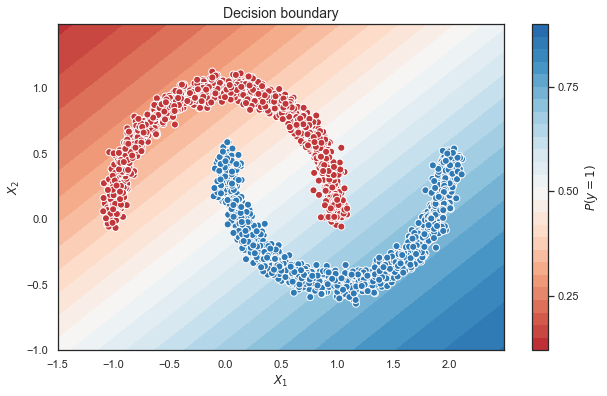

In [650]:
visualise_boundary(linear)